In [ ]:
## import os
import pandas as pd
import numpy as np
import math
from itertools import cycle
import tensorflow as tf
tf.enable_eager_execution()

In [10]:
# hyperparameters
NUM_EPOCHS = 250
LEARNING_RATE = 0.001
BATCH_SIZE_TRAIN = 16
BATCH_SIZE_VAL = 16


# default size of EfficientNet
IMG_SIZE = (224, 224)

GCS_OUTPUT = 'gs://tpuv3/bone-age/tfrecords-jpeg-224x224/bone'  # prefix for output file names

In [34]:
class_str_col = 'boneage'
gender_str_col = 'male'

base_bone_dir = os.path.join('rsna-bone-age')
boneage_df = pd.read_csv(os.path.join(base_bone_dir, 'train.csv'))
boneage_df['path'] = boneage_df['fileName'].map(lambda x: os.path.join(base_bone_dir,
                                                         'images',
                                                         x))
boneage_df['exists'] = boneage_df['path'].map(os.path.exists)
print(boneage_df['exists'].sum(), 'images found of', boneage_df.shape[0], 'total')
#boneage_df[gender_str_col] = boneage_df[gender_str_col].map(lambda x: True if x else False) # map boolean values to 1 and 0
boneage_df

11349 images found of 11349 total


,fileName,boneage,male,path,exists
0,2904.png,126,False,rsna-bone-age/images/2904.png,True
1,7464.png,180,True,rsna-bone-age/images/7464.png,True
2,6909.png,82,False,rsna-bone-age/images/6909.png,True
3,9134.png,156,False,rsna-bone-age/images/9134.png,True
4,2099.png,156,True,rsna-bone-age/images/2099.png,True
...,...,...,...,...,...
11344,4320.png,162,False,rsna-bone-age/images/4320.png,True
11345,6838.png,186,True,rsna-bone-age/images/6838.png,True
11346,4868.png,144,True,rsna-bone-age/images/4868.png,True
11347,2169.png,156,True,rsna-bone-age/images/2169.png,True


In [29]:
"""
import shutil
def move_to_train(path):
    folders = path.split('/')
    shutil.move(path, "/".join(folders[0:-2])+'/'+folders[-1])
boneage_df['path'].map(move_to_train)
"""

'\nimport shutil\ndef move_to_train(path):\n    folders = path.split(\'/\')\n    shutil.move(path, "/".join(folders[0:-2])+\'/\'+folders[-1])\nboneage_df[\'path\'].map(move_to_train)\n'

In [30]:
boneage_df['boneage'].describe()

count    11349.000000
mean       127.183629
std         41.194578
min          1.000000
25%         96.000000
50%        132.000000
75%        156.000000
max        228.000000
Name: boneage, dtype: float64

In [36]:
boneage_table = tf.contrib.lookup.HashTable(
  tf.contrib.lookup.KeyValueTensorInitializer(boneage_df['fileName'].values, boneage_df['boneage'].values), 0
)

In [37]:
male_table = tf.contrib.lookup.HashTable(
  tf.contrib.lookup.KeyValueTensorInitializer(boneage_df['fileName'].values, boneage_df['male'].values), True
)

In [43]:
IMG_PATTERN = 'rsna-bone-age/images/*.png'
SHARDS = 16
AUTO = tf.data.experimental.AUTOTUNE

nb_images = len(tf.gfile.Glob(IMG_PATTERN))
shard_size = math.ceil(1.0 * nb_images / SHARDS)
print("Pattern matches {} images which will be rewritten as {} .tfrec files containing {} images each.".format(nb_images, SHARDS, shard_size))

def decode_jpeg_and_label(filename):
  bits = tf.read_file(filename)
  image = tf.image.decode_png(bits, channels=3)
  # parse flower name from containing directory
  path = tf.strings.split(tf.expand_dims(filename, axis=-1), sep='/')
  label = tf.cast(boneage_table.lookup(path.values[-1]), tf.uint8)
  sex = tf.cast(male_table.lookup(path.values[-1]), tf.bool)
  return image, label, sex

filenames = tf.data.Dataset.list_files(IMG_PATTERN, seed=24)
dataset1 = filenames.map(decode_jpeg_and_label, num_parallel_calls=AUTO)

Pattern matches 11349 images which will be rewritten as 16 .tfrec files containing 710 images each.


In [44]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
def display_9_images_from_dataset(dataset):
  plt.figure(figsize=(13,13))
  subplot=331
  for i, (image, label, sex) in enumerate(dataset):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image.numpy().astype(np.uint8))
    plt.title(str(label.numpy()) + ' - ' + str(sex.numpy()), fontsize=16)
    subplot += 1
    if i==8:
      break
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

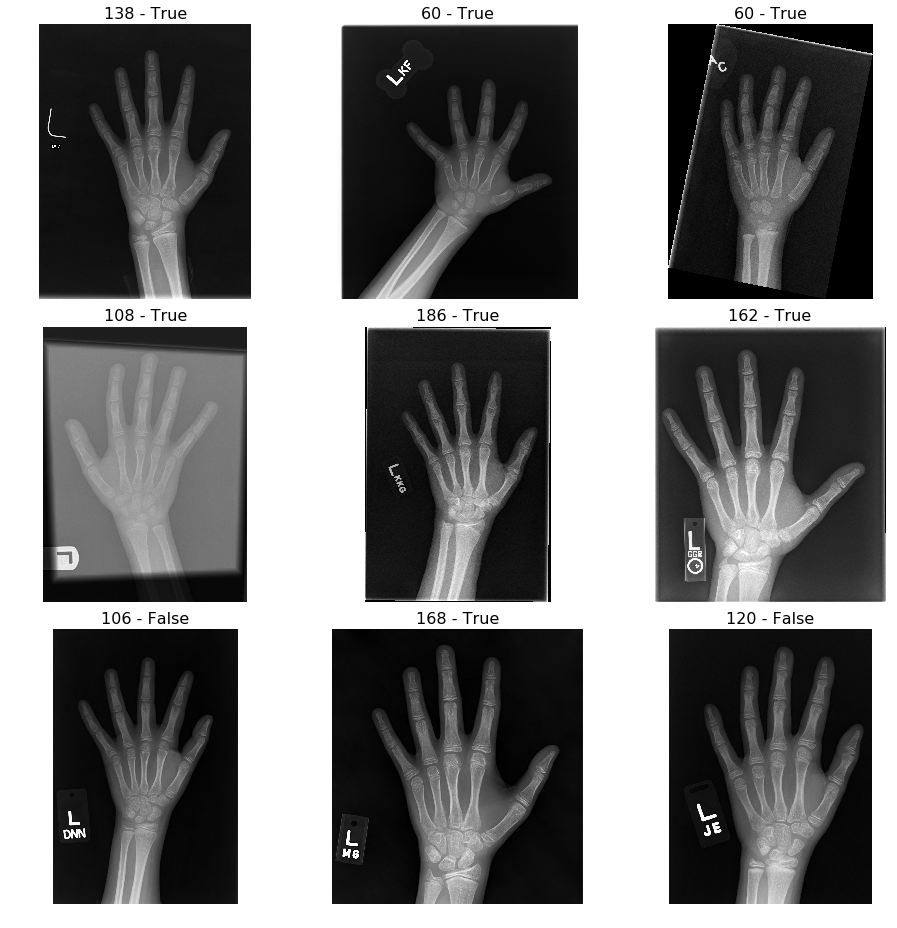

In [45]:
display_9_images_from_dataset(dataset1)

In [46]:
def resize_and_crop_image(image, label, sex):
  # Resize and crop using "fill" algorithm:
  # always make sure the the resulting image
  # is cut out from the source image so that
  # it fills the TARGET_SIZE entirely with no
  # black bars and a preserved aspect ratio.
  w = tf.shape(image)[0]
  h = tf.shape(image)[1]
  tw = IMG_SIZE[1]
  th = IMG_SIZE[0]
  resize_crit = (w * th) / (h * tw)
  image = tf.cond(resize_crit < 1,
                  lambda: tf.image.resize_images(image, [w*tw/w, h*tw/w]), # if true
                  lambda: tf.image.resize_images(image, [w*th/h, h*th/h])  # if false
                 )
  nw = tf.shape(image)[0]
  nh = tf.shape(image)[1]
  image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
  return image, label, sex
  
dataset2 = dataset1.map(resize_and_crop_image, num_parallel_calls=AUTO)  

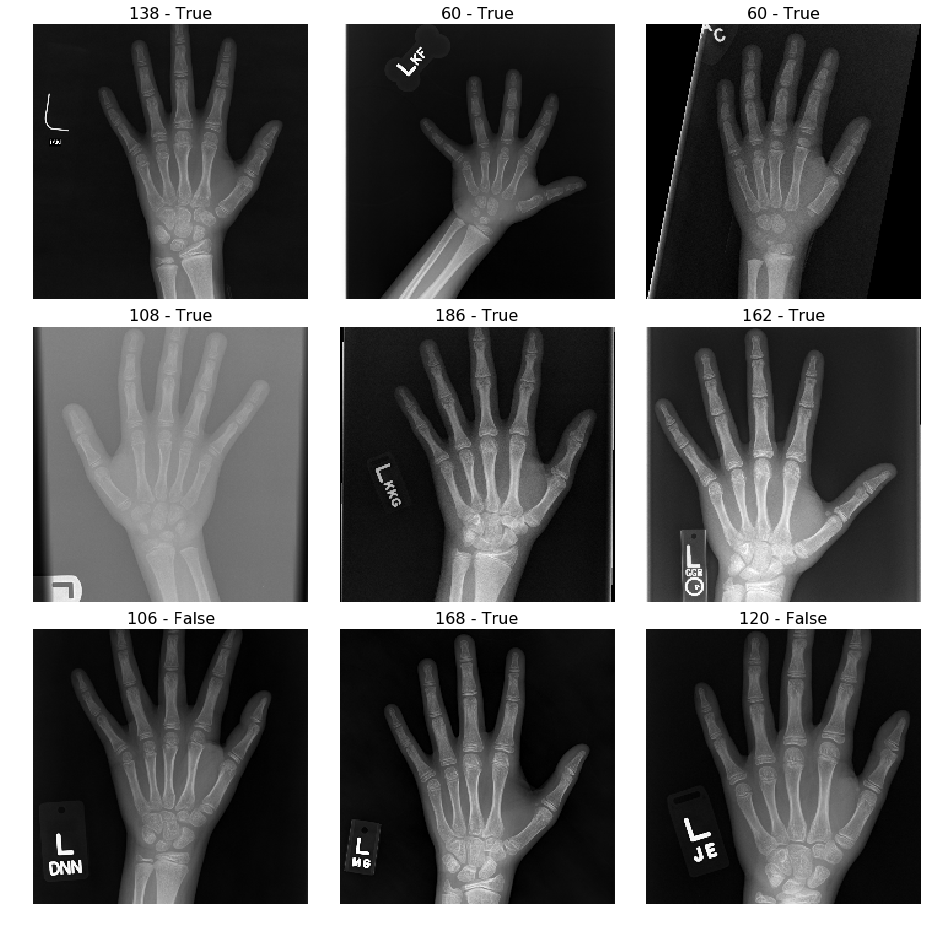

In [47]:
display_9_images_from_dataset(dataset2)

In [48]:
display_dataset = dataset2.batch(8)
for image, label, sex in display_dataset.take(30):
  print("Image batch shape {}, {}, {})".format(image.numpy().shape, [lbl for lbl in label.numpy()], sex))

Image batch shape (8, 224, 224, 3), [138, 60, 60, 108, 186, 162, 106, 168], [ True  True  True  True  True  True False  True])
Image batch shape (8, 224, 224, 3), [120, 156, 132, 168, 162, 82, 168, 150], [False False False  True  True False  True  True])
Image batch shape (8, 224, 224, 3), [120, 156, 27, 180, 162, 60, 120, 168], [ True False False False False  True  True  True])
Image batch shape (8, 224, 224, 3), [126, 126, 126, 132, 78, 156, 156, 186], [ True False False  True  True False  True  True])
Image batch shape (8, 224, 224, 3), [156, 120, 132, 108, 84, 88, 174, 106], [ True  True False  True False False False False])
Image batch shape (8, 224, 224, 3), [82, 138, 153, 138, 150, 96, 48, 82], [False  True  True  True  True  True  True False])
Image batch shape (8, 224, 224, 3), [150, 84, 57, 94, 120, 144, 82, 12], [ True  True  True False False False False  True])
Image batch shape (8, 224, 224, 3), [120, 150, 144, 106, 138, 132, 144, 132], [False  True  True False  True False

In [49]:
def recompress_image(image, label, sex):
  height = tf.shape(image)[0]
  width = tf.shape(image)[1]
  image = tf.cast(image, tf.uint8)
  image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
  return image, label, sex, height, width

dataset3 = dataset2.map(recompress_image, num_parallel_calls=AUTO)
dataset3 = dataset3.batch(shard_size) # sharding: there will be one "batch" of images per file 

In [51]:
# Three types of data can be stored in TFRecords: bytestrings, integers and floats
# They are always stored as lists, a single data element will be a list of size 1

def _bytestring_feature(list_of_bytestrings):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=list_of_bytestrings))

def _int_feature(list_of_ints): # int64
  return tf.train.Feature(int64_list=tf.train.Int64List(value=list_of_ints))

def _float_feature(list_of_floats): # float32
  return tf.train.Feature(float_list=tf.train.FloatList(value=list_of_floats))
  

def to_tfrecord(tfrec_filewriter, img_bytes, label, sex, height, width):  
  feature = {
      "image": _bytestring_feature([img_bytes]), # one image in the list      
      # additional (not very useful) fields to demonstrate TFRecord writing/reading of different types of data
      "label":         _int_feature([label]),          # fixed length (1) list of strings, the text label
      "sex":           _int_feature([sex]),
      "size":          _int_feature([height, width]),         # fixed length (2) list of ints
  }
  return tf.train.Example(features=tf.train.Features(feature=feature))
  
print("Writing TFRecords")
for shard, (image, label, sex, height, width) in enumerate(dataset3):
  # batch size used as shard size here
  shard_size = image.numpy().shape[0]
  # good practice to have the number of records in the filename
  filename = GCS_OUTPUT + "{:02d}-{}.tfrec".format(shard, shard_size)
  
  with tf.python_io.TFRecordWriter(filename) as out_file:
    for i in range(shard_size):
      example = to_tfrecord(out_file,
                            image.numpy()[i], # re-compressed image: already a byte string
                            label.numpy()[i],
                            sex.numpy()[i],
                            height.numpy()[i],
                            width.numpy()[i])
      out_file.write(example.SerializeToString())
    print("Wrote file {} containing {} records".format(filename, shard_size))

Writing TFRecords
Wrote file gs://tpuv3/bone-age/tfrecords-jpeg-224x224/bone00-710.tfrec containing 710 records
Wrote file gs://tpuv3/bone-age/tfrecords-jpeg-224x224/bone01-710.tfrec containing 710 records
Wrote file gs://tpuv3/bone-age/tfrecords-jpeg-224x224/bone02-710.tfrec containing 710 records
Wrote file gs://tpuv3/bone-age/tfrecords-jpeg-224x224/bone03-710.tfrec containing 710 records
Wrote file gs://tpuv3/bone-age/tfrecords-jpeg-224x224/bone04-710.tfrec containing 710 records
Wrote file gs://tpuv3/bone-age/tfrecords-jpeg-224x224/bone05-710.tfrec containing 710 records
Wrote file gs://tpuv3/bone-age/tfrecords-jpeg-224x224/bone06-710.tfrec containing 710 records
Wrote file gs://tpuv3/bone-age/tfrecords-jpeg-224x224/bone07-710.tfrec containing 710 records
Wrote file gs://tpuv3/bone-age/tfrecords-jpeg-224x224/bone08-710.tfrec containing 710 records
Wrote file gs://tpuv3/bone-age/tfrecords-jpeg-224x224/bone09-710.tfrec containing 710 records
Wrote file gs://tpuv3/bone-age/tfrecords-j